In [1]:
%matplotlib inline

# Siamese CNN - MNIST
In this exercise, we will employ a siamese structure to classify if two handwritten images from MNIST represent the same digit or not. 

The siamese architecture will have two branches that share weights and act as feature extrators to the input images. The output of our network is the euclidean distance of both feature vectors. Based on that, we can use a threshold (we will use 0.5 in this example) to determine if both images depict the same digit or not. 


# Imports

In [2]:
import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Convolution2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Utility functions

In [3]:
#Compute classification accuracy with a fixed threshold on distances.
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

#Compute the euclidean distance of two arrays
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

#Plot a pair of images
def plotPair(img1, img2):
    plt.subplot(1,2,1)
    plt.imshow(img1.reshape(28,28), cmap='gray', interpolation='none')
    plt.subplot(1,2,2)
    plt.imshow(img2.reshape(28,28), cmap='gray', interpolation='none')
    plt.show()

# MNIST Dataset
We will use our great friend MNIST for this task. In order to train our siamese network, we will need pairs of images, representing both "classes" of our new problem. As we will work with two images, our goal will be to tell if both of them represent the same digit (class 1) or not (class 0). 

We will need to create pairs from the images available in MNIST dataset. The `create_pairs` method makes random pairs of two images, alternating between positive and negative pairs (in order to have a balanced batch/dataset). We also pre-process our images just like we did before. 

In [4]:
num_classes = 10
input_shape = (28,28,1)
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1 #finds the class with fewer samples
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1] #positive pair
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i] #negative pair
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)] #find the ind
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)
print(tr_pairs.shape, tr_y.shape)

11493376/11490434 [==============================] - 12s 1us/step
(108400, 2, 28, 28, 1) (108400,)


# Siamese Architecture
We will use a simple CNN as our base model:

In [5]:
#Base network to be shared (eq. to feature extraction).
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Convolution2D(10, (3,3), activation='relu')(input)
    x = MaxPooling2D((2,2))(x)
    x = Convolution2D(20, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu')(x) # <-------- not the number of classes
    return Model(input, x)

We will instantiate a `base_network` using the method above. Note that we will only define a single `base_network`, even though it will process each of the input images. This way, its weights will be shared and, at the long run, our network will learn discriminative features to capture the difference/similarity between both images of the pair.

In [9]:
base_network = create_base_network((input_shape))

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance)([processed_a, processed_b])
model = Model([input_a, input_b], distance)

# Training

For training, we will use the `contrastive_loss` which is a distance-based loss function. It receives the output of our network (euclidean distance) and the expected prediction (1 for pairs of the same digit and 0 for pairs of different digits). 

It will maximize the distance of negative pairs while minimizing the distance of positive pairs. The `margin` refers to the minimum distance aimed for the negative pairs. If a negative pair has a distance greater than the margin, it will not be accounted for the loss. 

<img src='contrastive_loss.png' width=80%>

In [10]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

# Compilation
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy]) #<-- different accuracy metric

# Training
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=32, epochs=2,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 108400 samples, validate on 17820 samples
Epoch 1/2
108400/108400 [==============================] - 60s 557us/step - loss: 0.0741 - accuracy: 0.9346 - val_loss: 0.0346 - val_accuracy: 0.9787
Epoch 2/2
108400/108400 [==============================] - 63s 577us/step - loss: 0.0421 - accuracy: 0.9722 - val_loss: 0.0292 - val_accuracy: 0.9829


# Testing
Let's examine some pairs and their distance:

Comparing  1  with  0 		Euclidean Distance =  [[1.0322648]]


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


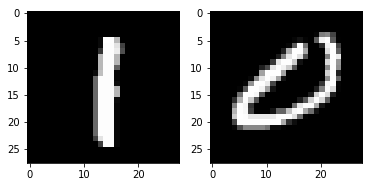

Comparing  1  with  0 		Euclidean Distance =  [[1.0396054]]


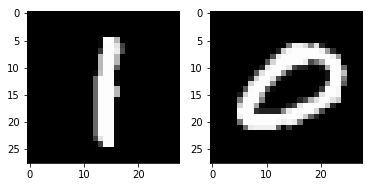

Comparing  1  with  1 		Euclidean Distance =  [[0.00031623]]


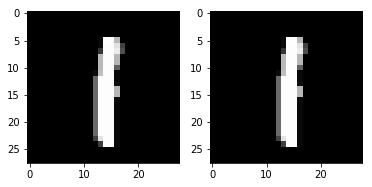

Comparing  1  with  1 		Euclidean Distance =  [[0.11316814]]


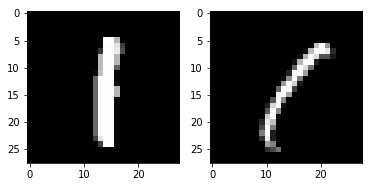

Comparing  1  with  2 		Euclidean Distance =  [[0.9648837]]


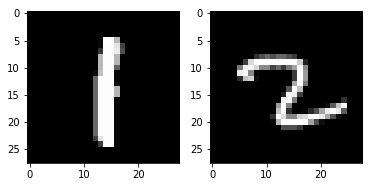

Comparing  1  with  2 		Euclidean Distance =  [[0.99066]]


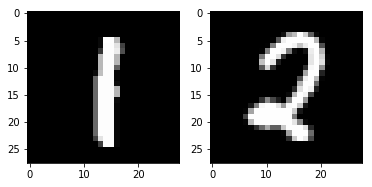

Comparing  1  with  3 		Euclidean Distance =  [[0.9402326]]


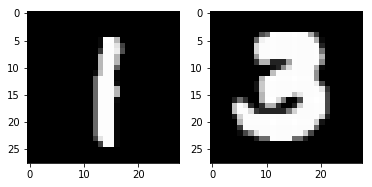

Comparing  1  with  3 		Euclidean Distance =  [[1.0519003]]


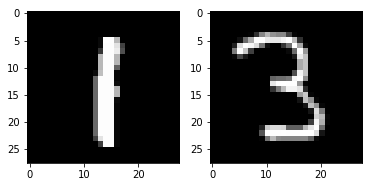

Comparing  1  with  4 		Euclidean Distance =  [[0.9637638]]


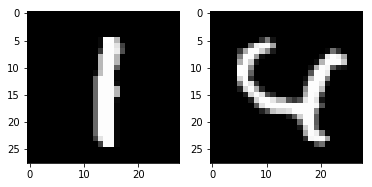

Comparing  1  with  4 		Euclidean Distance =  [[0.8329005]]


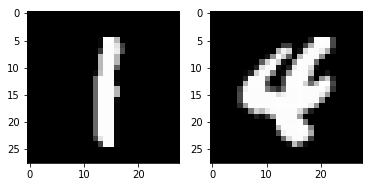

Comparing  1  with  5 		Euclidean Distance =  [[0.9112911]]


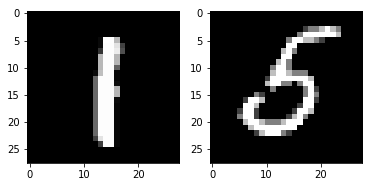

Comparing  1  with  5 		Euclidean Distance =  [[1.1044788]]


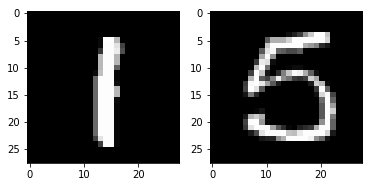

Comparing  1  with  6 		Euclidean Distance =  [[1.0360819]]


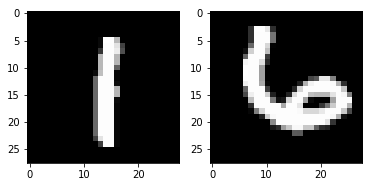

Comparing  1  with  6 		Euclidean Distance =  [[1.0722895]]


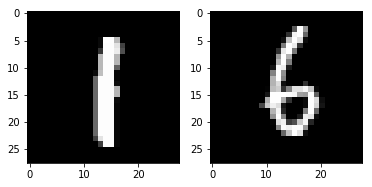

Comparing  1  with  7 		Euclidean Distance =  [[1.0759608]]


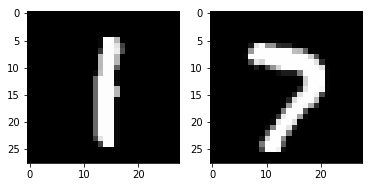

Comparing  1  with  7 		Euclidean Distance =  [[0.99190456]]


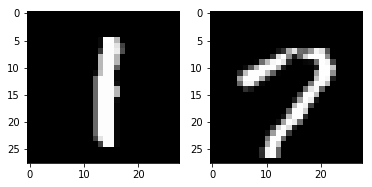

Comparing  1  with  8 		Euclidean Distance =  [[0.9788308]]


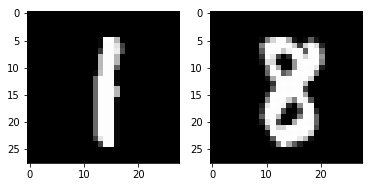

Comparing  1  with  8 		Euclidean Distance =  [[0.92067]]


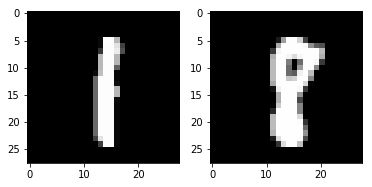

Comparing  1  with  9 		Euclidean Distance =  [[1.0013204]]


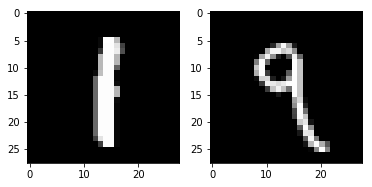

Comparing  1  with  9 		Euclidean Distance =  [[1.0512128]]


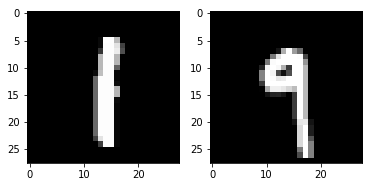

In [11]:
from sklearn.cross_validation import StratifiedShuffleSplit    #Get a random image from each class in test
splitIdx = StratifiedShuffleSplit(y_test, 1, test_size= 2 * num_classes)
for _, idx in splitIdx:
   Sx = x_test[idx]
   Sy = y_test[idx]
   
a = list(zip(Sx, Sy))
a.sort(key = lambda t: t[1])

idx = 1   #<----- change here to test other digits, 0 to num_classes-1
idx = idx * 2
randomSample = a[idx][0]
for i in list(range(0,2*num_classes)):
   distance = model.predict([randomSample.reshape(1,28,28,1), a[i][0].reshape(1,28,28,1)])
   print("Comparing ", a[idx][1], " with ", a[i][1], "\t\tEuclidean Distance = ", distance)
   plotPair(randomSample, a[i][0])